# MLP Ensemble Flight Delay Prediction

This notebook trains an **ensemble of 3 MLP models** with different class balancing strategies:
- **Model 1**: 50:50 undersampling (balanced)
- **Model 2**: 40:60 undersampling (favor delayed class)
- **Model 3**: Original data with aggressive class weights

The final prediction is an **averaged ensemble** with optimized threshold.

**Key Features:**
- Optional Optuna hyperparameter tuning for each model
- Threshold optimization for each model and the ensemble
- Comprehensive evaluation metrics
- Strategic caching and leakage detection

---
## 1. Configuration & Setup

In [0]:
# ============================================================
# IMPORTS
# ============================================================
from pyspark.sql.functions import col, sum as spark_sum, count as spark_count, rand
from pyspark.sql.types import StringType, NumericType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    average_precision_score, roc_auc_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    classification_report, precision_recall_curve, fbeta_score
)

print(f"PySpark version: {spark.version}")
print("Imports loaded successfully.")

PySpark version: 3.5.2
Imports loaded successfully.


In [0]:
# ============================================================
# CONFIGURATION
# ============================================================
# Data paths
TRAIN_PATH = "dbfs:/student-groups/Group_4_4/cp6_train_2015_2017_refined.parquet"
VAL_PATH = "dbfs:/student-groups/Group_4_4/cp6_val_2018_refined.parquet"
TEST_PATH = "dbfs:/student-groups/Group_4_4/cp6_test_2019_refined.parquet"

# Constants
LABEL_COL = "DEP_DEL15"  # Binary delay indicator
RANDOM_SEED = 42

# Ensemble configuration
ENABLE_OPTUNA = True  # Set True to tune each model (takes longer)
N_TRIALS_PER_MODEL = 10  # Trials per model if Optuna enabled
TUNE_FRACTION = 0.1  # Fraction of training data for tuning

# Default model architecture (if not using Optuna)
DEFAULT_LAYERS = [128, 64, 32]  # Hidden layers
MAX_ITER = 100

# Post-departure features (leakage detection)
POST_DEPARTURE_KEYWORDS = [
    'arr_', 'actual_elapsed', 'air_time', 'taxi_out', 'wheels_off',
    'wheels_on', 'taxi_in', 'diverted', 'cancelled', 'cancellation',
    'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
    'late_aircraft_delay'
]

EXPLICIT_LEAKAGE_COLS = ['CANCELLED', 'DIVERTED']

print("Configuration loaded.")

Configuration loaded.


---
## 2. Load Data

In [0]:
# ============================================================
# LOAD DATA
# ============================================================
print("Loading data...")

df_train = spark.read.parquet(TRAIN_PATH)
df_val = spark.read.parquet(VAL_PATH)
df_test = spark.read.parquet(TEST_PATH)

train_count = train_df.count()
val_count = val_df.count()
test_count = test_df.count()

print(f"Train: {train_count:,} samples")
print(f"Val:   {val_count:,} samples")
print(f"Test:  {test_count:,} samples")

Loading data...
Train: 16,804,556 samples
Val:   7,065,328 samples
Test:  7,259,007 samples


---
## 3. Leakage Detection

In [0]:
# ============================================================
# LEAKAGE DETECTION - Remove Post-Departure Features
# ============================================================
print("Checking for potential data leakage...\n")

# Keywords that indicate post-departure information
post_departure_keywords = [
    "ARR_",       # Arrival-related (known only after landing)
    "WHEELS_",    # Wheels off/on (known only during flight)
    "TAXI_",      # Taxi time (known only after departure)
    "AIR_TIME",   # Air time (known only after landing)
    "ACTUAL_",    # Actual times (known only after events occur)
]

# Check all columns for leakage
leakage_cols = []
for col_name in df_train.columns:
    col_upper = col_name.upper()
    if any(keyword in col_upper for keyword in post_departure_keywords):
        leakage_cols.append(col_name)

# Explicit leakage columns (known post-departure information)
explicit_leakage = [
    "CANCELLED",           # Only known after scheduled departure
    "CANCELLATION_CODE",   # Only known if cancelled
    "DIVERTED",            # Only known during/after flight
    "DEP_DELAY",           # Continuous delay (we only keep DEP_DEL15, the binary label)
    "DEP_TIME",            # Actual departure time (we use scheduled CRS_DEP_TIME)
]

# Add explicit leakage columns if they exist
for col_name in explicit_leakage:
    if col_name in df_train.columns and col_name not in leakage_cols:
        leakage_cols.append(col_name)

# Also remove ID columns that don't provide predictive value
id_cols = [
    "FL_DATE",           # Date is captured in other features
    "prediction_utc",    # Internal timestamp
    "origin_obs_utc",    # Internal timestamp
    "OP_CARRIER_FL_NUM", # Flight number (too specific)
]

for col_name in id_cols:
    if col_name in df_train.columns and col_name not in leakage_cols:
        leakage_cols.append(col_name)

# Remove duplicates
leakage_or_id_cols = sorted(list(set(leakage_cols)))

if leakage_or_id_cols:
    print(f"Detected and removing {len(leakage_or_id_cols)} leakage/ID columns:")
    for col_name in leakage_or_id_cols:
        print(f"  - {col_name}")
    
    # Remove from all datasets
    df_train = df_train.drop(*leakage_or_id_cols)
    df_val = df_val.drop(*leakage_or_id_cols)
    df_test = df_test.drop(*leakage_or_id_cols)
    
    print(f"\nColumns after leakage removal:")
    print(f"  Train: {len(df_train.columns)} columns")
    print(f"  Val: {len(df_val.columns)} columns")
    print(f"  Test: {len(df_test.columns)} columns")
else:
    print("No leakage columns detected.")

print("\nLeakage detection complete!")


Checking for potential data leakage...

Detected and removing 8 leakage/ID columns:
  - CRS_ARR_TIME
  - DEP_DELAY
  - FL_DATE
  - OP_CARRIER_FL_NUM
  - arr_time_cos
  - arr_time_sin
  - origin_obs_utc
  - prediction_utc

Columns after leakage removal:
  Train: 105 columns
  Val: 105 columns
  Test: 105 columns

Leakage detection complete!


---
## 4. Feature Engineering Pipeline

In [0]:
# ============================================================
# IDENTIFY FEATURE TYPES
# ============================================================
print("Identifying feature types...\n")

# Get all columns except label
all_feature_cols = [col_name for col_name in df_train.columns if col_name != LABEL_COL]

# Identify categorical columns (string type, not already indexed)
categorical_cols = [
    field.name for field in df_train.schema.fields 
    if isinstance(field.dataType, StringType) 
    and field.name != LABEL_COL
    and not field.name.endswith("_indexed")
]

# Identify numeric columns (excluding label and already indexed columns)
numeric_cols = [
    field.name for field in df_train.schema.fields 
    if isinstance(field.dataType, NumericType) 
    and field.name != LABEL_COL
    and not field.name.endswith("_indexed")
]

# Check if data is already indexed (has _indexed columns)
already_indexed_cols = [col_name for col_name in df_train.columns if col_name.endswith("_indexed")]

print(f"Feature Summary:")
print(f"  Total features: {len(all_feature_cols)}")
print(f"  Categorical (string) features: {len(categorical_cols)}")
print(f"  Numeric features: {len(numeric_cols)}")
print(f"  Already indexed features: {len(already_indexed_cols)}")

if categorical_cols:
    print(f"\nCategorical columns to encode:")
    for col_name in categorical_cols[:10]:  # Show first 10
        print(f"  - {col_name}")
    if len(categorical_cols) > 10:
        print(f"  ... and {len(categorical_cols) - 10} more")

if already_indexed_cols:
    print(f"\nNote: Found {len(already_indexed_cols)} pre-indexed columns.")
    print("Will use these instead of re-indexing.")

Identifying feature types...

Feature Summary:
  Total features: 104
  Categorical (string) features: 12
  Numeric features: 80
  Already indexed features: 12

Categorical columns to encode:
  - DEST
  - ORIGIN
  - OP_UNIQUE_CARRIER
  - ORIGIN_STATE_ABR
  - DEST_STATE_ABR
  - origin_type
  - season
  - weather_condition_category
  - airline_reputation_category
  - turnaround_category
  ... and 2 more

Note: Found 12 pre-indexed columns.
Will use these instead of re-indexing.


In [0]:
# ============================================================
# BUILD FEATURE ENGINEERING PIPELINE
# ============================================================
print("Building feature engineering pipeline...\n")

# If data is already indexed, use indexed columns
if already_indexed_cols:
    print("Using pre-indexed features from upstream processing.")
    
    # Use already indexed columns + numeric columns
    feature_cols = already_indexed_cols + numeric_cols
    
    # Assemble features
    assembler = VectorAssembler(
        inputCols=feature_cols,
        outputCol="features_raw",
        handleInvalid="skip"
    )
    
    # Scale features
    scaler = StandardScaler(
        inputCol="features_raw",
        outputCol="features",
        withMean=True,
        withStd=True
    )
    
    # Create pipeline
    pipeline = Pipeline(stages=[assembler, scaler])
    
else:
    print("No pre-indexed features found. Building full indexing pipeline.")
    
    # Stage 1: String Indexing
    indexers = [
        StringIndexer(
            inputCol=col_name,
            outputCol=f"{col_name}_indexed",
            handleInvalid="keep"
        )
        for col_name in categorical_cols
    ]
    
    # Get indexed column names
    indexed_cols = [f"{col_name}_indexed" for col_name in categorical_cols]
    
    # Stage 2: Assemble all features
    feature_cols = indexed_cols + numeric_cols
    assembler = VectorAssembler(
        inputCols=feature_cols,
        outputCol="features_raw",
        handleInvalid="skip"
    )
    
    # Stage 3: Scale features
    scaler = StandardScaler(
        inputCol="features_raw",
        outputCol="features",
        withMean=True,
        withStd=True
    )
    
    # Create pipeline
    pipeline = Pipeline(stages=indexers + [assembler, scaler])

print(f"Pipeline stages: {len(pipeline.getStages())}")
print(f"Total features to use: {len(feature_cols)}")
print("\nPipeline built successfully!")

Building feature engineering pipeline...

Using pre-indexed features from upstream processing.
Pipeline stages: 2
Total features to use: 92

Pipeline built successfully!


---
## 5. Fit Pipeline & Prepare Datasets

In [0]:
# ============================================================
# APPLY FEATURE ENGINEERING PIPELINE
# ============================================================
print("Applying feature engineering pipeline...\n")
start_time = time.time()

# Fit pipeline on training data
print("Fitting pipeline on training data...")
pipeline_model = pipeline.fit(df_train)

# Transform all datasets
print("Transforming datasets...")
train_prepared = pipeline_model.transform(df_train)
val_prepared = pipeline_model.transform(df_val)
test_prepared = pipeline_model.transform(df_test)

elapsed = time.time() - start_time

# Get input size
input_size = len(train_prepared.first().features)
print(f"\nInput feature dimension: {input_size}")
print(f"\nFeature engineering complete in {elapsed:.2f}s")
print(f"\nOutput columns: {len(train_prepared.columns)}")
print(f"Key columns: features, {LABEL_COL}")

Applying feature engineering pipeline...

Fitting pipeline on training data...
Transforming datasets...

Input feature dimension: 92

Feature engineering complete in 12.13s

Output columns: 107
Key columns: features, DEP_DEL15


---
## 6. Class Distribution Analysis

In [0]:
# ============================================================
# CLASS DISTRIBUTION
# ============================================================
print("\n" + "="*60)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*60)

class_dist = train_prepared.groupBy(LABEL_COL).count().collect()
class_counts = {row[LABEL_COL]: row["count"] for row in class_dist}
total = sum(class_counts.values())

print(f"\nOriginal Training Distribution:")
for cls in sorted(class_counts.keys()):
    label_name = "On-time" if cls == 0 else "Delayed"
    pct = 100 * class_counts[cls] / total
    print(f"  Class {cls} ({label_name}): {class_counts[cls]:,} ({pct:.2f}%)")

# Calculate imbalance ratio
imbalance_ratio = class_counts[0] / class_counts[1]
print(f"\nImbalance ratio (majority/minority): {imbalance_ratio:.2f}:1")

# Store for later use
class_0_count = class_counts[0]
class_1_count = class_counts[1]


CLASS DISTRIBUTION ANALYSIS

Original Training Distribution:
  Class 0 (On-time): 13,483,361 (81.94%)
  Class 1 (Delayed): 2,971,622 (18.06%)

Imbalance ratio (majority/minority): 4.54:1


---
## 7. Create Balanced Datasets for Each Model

In [0]:
# ============================================================
# CREATE BALANCED DATASETS
# ============================================================
print("\n" + "="*60)
print("CREATING BALANCED DATASETS FOR ENSEMBLE")
print("="*60)

# Separate classes
train_class_0 = train_prepared.filter(col(LABEL_COL) == 0)
train_class_1 = train_prepared.filter(col(LABEL_COL) == 1)

# ========== MODEL 1: 50:50 Balance ==========
print("\nModel 1: Creating 50:50 balanced dataset...")
target_count_m1 = class_1_count  # Match minority class
sample_fraction_m1 = target_count_m1 / class_0_count

train_m1_class0 = train_class_0.sample(withReplacement=False, fraction=sample_fraction_m1, seed=RANDOM_SEED)
train_m1 = train_m1_class0.union(train_class_1).cache()
train_m1_count = train_m1.count()

print(f"  Total samples: {train_m1_count:,}")
print(f"  Class 0: ~{train_m1_count//2:,} (50%)")
print(f"  Class 1: ~{train_m1_count//2:,} (50%)")

# ========== MODEL 2: 40:60 Balance (Favor Delayed) ==========
print("\nModel 2: Creating 40:60 balanced dataset (favor delayed)...")
target_count_m2 = int(class_1_count * 0.67)  # 40:60 ratio means class_0 = 0.67 * class_1
sample_fraction_m2 = target_count_m2 / class_0_count

train_m2_class0 = train_class_0.sample(withReplacement=False, fraction=sample_fraction_m2, seed=RANDOM_SEED + 1)
train_m2 = train_m2_class0.union(train_class_1).cache()
train_m2_count = train_m2.count()

print(f"  Total samples: {train_m2_count:,}")
print(f"  Class 0: ~{int(train_m2_count*0.4):,} (40%)")
print(f"  Class 1: ~{int(train_m2_count*0.6):,} (60%)")

# ========== MODEL 3: Original Data with Class Weights ==========
print("\nModel 3: Using original data with aggressive class weights...")
train_m3 = train_prepared  # Already cached

# Calculate aggressive class weights
class_3_weight_1 = (total / class_1_count) * 2.5  # 2.5x more aggressive
class_3_weight_0 = (total / class_0_count) * 0.4  # Reduce majority class

CLASS_WEIGHTS_M3 = {
    0: class_3_weight_0,
    1: class_3_weight_1
}

print(f"  Total samples: {total:,}")
print(f"  Class weights: {CLASS_WEIGHTS_M3}")

print("\n All training datasets prepared.")


CREATING BALANCED DATASETS FOR ENSEMBLE

Model 1: Creating 50:50 balanced dataset...
  Total samples: 5,945,573
  Class 0: ~2,972,786 (50%)
  Class 1: ~2,972,786 (50%)

Model 2: Creating 40:60 balanced dataset (favor delayed)...
  Total samples: 4,965,869
  Class 0: ~1,986,347 (40%)
  Class 1: ~2,979,521 (60%)

Model 3: Using original data with aggressive class weights...
  Total samples: 16,454,983
  Class weights: {0: 0.4881567140418476, 1: 13.843435504246502}

 All training datasets prepared.


---
## 8. Optional: Hyperparameter Tuning with Optuna

In [0]:
# ============================================================
# OPTUNA HYPERPARAMETER TUNING
# ============================================================
ENABLE_OPTUNA_PLOTS = True  # <-- turn this on/off to show Optuna graphs

if ENABLE_OPTUNA:
    print("\n" + "="*60)
    print("OPTUNA HYPERPARAMETER TUNING")
    print("="*60)
    
    import optuna
    from optuna.samplers import TPESampler
    import optuna.visualization as ov  # for interactive plots (Plotly)

    # Sample tuning data
    train_tune_m1 = train_m1.sample(withReplacement=False, fraction=TUNE_FRACTION, seed=RANDOM_SEED)
    train_tune_m2 = train_m2.sample(withReplacement=False, fraction=TUNE_FRACTION, seed=RANDOM_SEED)
    train_tune_m3 = train_m3.sample(withReplacement=False, fraction=TUNE_FRACTION, seed=RANDOM_SEED)
    
    val_tune = val_prepared.sample(withReplacement=False, fraction=TUNE_FRACTION, seed=RANDOM_SEED)
    
    def objective_factory(train_data, model_name, class_weights=None):
        """Factory to create objective function for each model"""
        def objective(trial):
            # Suggest hyperparameters
            # NOTE: (low, high) for n_hidden_layers
            n_hidden = trial.suggest_int("n_hidden_layers", 1, 3)
            layers = [input_size]
            
            for i in range(n_hidden):
                layer_size = trial.suggest_int(f"hidden_{i}_size", 32, 256)
                layers.append(layer_size)
            
            layers.append(2)  # Output layer
            
            max_iter = trial.suggest_int("max_iter", 50, 150)
            
            # Train model
            mlp = MultilayerPerceptronClassifier(
                layers=layers,
                maxIter=max_iter,
                seed=RANDOM_SEED,
                labelCol=LABEL_COL,
                featuresCol="features"
            )
            
            if class_weights:
                # mlp.setWeightCol("class_weight")  # Would need to add weight column
                pass
            
            model = mlp.fit(train_data)
            predictions = model.transform(val_tune)
            
            # Evaluate (using AUC-PR as primary metric)
            evaluator = BinaryClassificationEvaluator(
                labelCol=LABEL_COL,
                metricName="areaUnderPR"
            )
            
            aupr = evaluator.evaluate(predictions)
            return aupr
        
        return objective
    
    # Tune each model
    best_params = {}
    
    for model_name, train_data, use_weights in [
        ("Model_1", train_tune_m1, None),
        ("Model_2", train_tune_m2, None),
        ("Model_3", train_tune_m3, CLASS_WEIGHTS_M3),
    ]:
        print(f"\nTuning {model_name}...")
        study = optuna.create_study(
            direction="maximize",
            sampler=TPESampler(seed=RANDOM_SEED)
        )
        
        study.optimize(
            objective_factory(train_data, model_name, use_weights),
            n_trials=N_TRIALS_PER_MODEL,
            show_progress_bar=True
        )
        
        best_params[model_name] = study.best_params
        print(f"  Best AUPR: {study.best_value:.4f}")
        print(f"  Best params: {study.best_params}")

        # ============================================================
        # OPTUNA PLOTS PER MODEL (optional)
        # ============================================================
        if ENABLE_OPTUNA_PLOTS:
            print(f"  Generating Optuna plots for {model_name}...")
            try:
                # Optimization history
                ov.plot_optimization_history(study).show()
                # Parameter importance
                ov.plot_param_importances(study).show()
                # Slice plot (metric vs params)
                ov.plot_slice(study).show()
                # Parallel coordinate (param interactions)
                ov.plot_parallel_coordinate(study).show()
                # Contour (2D relationships)
                ov.plot_contour(study).show()
                # Empirical distribution of trial values
                ov.plot_edf(study).show()
            except Exception as e:
                print(f"    [WARN] Could not render Optuna plots for {model_name}: {e}")
    
    print("\n Hyperparameter tuning complete.")
    
else:
    print("\n  Skipping Optuna tuning. Using default architecture.")
    best_params = {
        "Model_1": {"layers": [input_size] + DEFAULT_LAYERS + [2], "max_iter": MAX_ITER},
        "Model_2": {"layers": [input_size] + DEFAULT_LAYERS + [2], "max_iter": MAX_ITER},
        "Model_3": {"layers": [input_size] + DEFAULT_LAYERS + [2], "max_iter": MAX_ITER},
    }



OPTUNA HYPERPARAMETER TUNING


[I 2025-12-10 17:59:42,992] A new study created in memory with name: no-name-596d2c40-beec-4617-acae-9eca0e8e6a8a



Tuning Model_1...


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-10 18:02:15,879] Trial 0 finished with value: 0.6316638697898629 and parameters: {'n_hidden_layers': 2, 'hidden_0_size': 245, 'hidden_1_size': 196, 'max_iter': 110}. Best is trial 0 with value: 0.6316638697898629.
[I 2025-12-10 18:02:39,890] Trial 1 finished with value: 0.584010398684461 and parameters: {'n_hidden_layers': 1, 'hidden_0_size': 67, 'max_iter': 55}. Best is trial 0 with value: 0.6316638697898629.
[I 2025-12-10 18:04:50,015] Trial 2 finished with value: 0.6570011857589515 and parameters: {'n_hidden_layers': 3, 'hidden_0_size': 167, 'hidden_1_size': 191, 'hidden_2_size': 36, 'max_iter': 147}. Best is trial 2 with value: 0.6570011857589515.
[I 2025-12-10 18:05:50,321] Trial 3 finished with value: 0.6167160267320342 and parameters: {'n_hidden_layers': 3, 'hidden_0_size': 79, 'hidden_1_size': 72, 'hidden_2_size': 73, 'max_iter': 80}. Best is trial 2 with value: 0.6570011857589515.
[I 2025-12-10 18:06:59,751] Trial 4 finished with value: 0.6333759797667898 and parame

[I 2025-12-10 18:12:58,216] A new study created in memory with name: no-name-fcbf348a-b0c3-4437-8b9c-4ec94238b628



Tuning Model_2...


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-10 18:17:39,730] Trial 0 finished with value: 0.6253403643997297 and parameters: {'n_hidden_layers': 2, 'hidden_0_size': 245, 'hidden_1_size': 196, 'max_iter': 110}. Best is trial 0 with value: 0.6253403643997297.
[I 2025-12-10 18:18:15,013] Trial 1 finished with value: 0.5753909021755836 and parameters: {'n_hidden_layers': 1, 'hidden_0_size': 67, 'max_iter': 55}. Best is trial 0 with value: 0.6253403643997297.
[I 2025-12-10 18:21:07,838] Trial 2 finished with value: 0.6587963146060329 and parameters: {'n_hidden_layers': 3, 'hidden_0_size': 167, 'hidden_1_size': 191, 'hidden_2_size': 36, 'max_iter': 147}. Best is trial 2 with value: 0.6587963146060329.
[I 2025-12-10 18:23:24,486] Trial 3 finished with value: 0.6196626129410138 and parameters: {'n_hidden_layers': 3, 'hidden_0_size': 79, 'hidden_1_size': 72, 'hidden_2_size': 73, 'max_iter': 80}. Best is trial 2 with value: 0.6587963146060329.
[I 2025-12-10 18:25:05,274] Trial 4 finished with value: 0.6362220723100129 and param

[I 2025-12-10 18:32:35,355] A new study created in memory with name: no-name-baaa1c70-0365-49aa-954f-879e578ef5f6



Tuning Model_3...


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-10 18:36:33,401] Trial 0 finished with value: 0.6317930681217059 and parameters: {'n_hidden_layers': 2, 'hidden_0_size': 245, 'hidden_1_size': 196, 'max_iter': 110}. Best is trial 0 with value: 0.6317930681217059.
[I 2025-12-10 18:37:01,838] Trial 1 finished with value: 0.5994233438501075 and parameters: {'n_hidden_layers': 1, 'hidden_0_size': 67, 'max_iter': 55}. Best is trial 0 with value: 0.6317930681217059.
[I 2025-12-10 18:42:45,390] Trial 2 finished with value: 0.6648812504714879 and parameters: {'n_hidden_layers': 3, 'hidden_0_size': 167, 'hidden_1_size': 191, 'hidden_2_size': 36, 'max_iter': 147}. Best is trial 2 with value: 0.6648812504714879.
[I 2025-12-10 18:44:10,978] Trial 3 finished with value: 0.6189777613305675 and parameters: {'n_hidden_layers': 3, 'hidden_0_size': 79, 'hidden_1_size': 72, 'hidden_2_size': 73, 'max_iter': 80}. Best is trial 2 with value: 0.6648812504714879.
[I 2025-12-10 18:46:04,646] Trial 4 finished with value: 0.6385840390334183 and param


 Hyperparameter tuning complete.


---
## 9. Train Model 1 (50:50 Balance)

In [0]:
# ============================================================
# TRAIN MODEL 1: 50:50 BALANCE
# ============================================================
print("\n" + "="*60)
print("TRAINING MODEL 1 (50:50 Balance)")
print("="*60)

if ENABLE_OPTUNA:
    params_m1 = best_params["Model_1"]
    layers_m1 = [input_size]
    for i in range(params_m1['n_hidden_layers']):
        layers_m1.append(params_m1[f'hidden_{i}_size'])
    layers_m1.append(2)
    max_iter_m1 = params_m1['max_iter']
else:
    layers_m1 = best_params["Model_1"]["layers"]
    max_iter_m1 = best_params["Model_1"]["max_iter"]

print(f"Architecture: {layers_m1}")
print(f"Max iterations: {max_iter_m1}")

start_time = time.time()

mlp_m1 = MultilayerPerceptronClassifier(
    layers=layers_m1,
    maxIter=max_iter_m1,
    seed=RANDOM_SEED,
    labelCol=LABEL_COL,
    featuresCol="features"
)

model_1 = mlp_m1.fit(train_m1)
training_time_m1 = time.time() - start_time

print(f"\n Model 1 trained in {training_time_m1:.2f}s")


TRAINING MODEL 1 (50:50 Balance)
Architecture: [92, 167, 191, 36, 2]
Max iterations: 147

 Model 1 trained in 1345.19s


---
## 10. Train Model 2 (40:60 Balance)

In [0]:
# ============================================================
# TRAIN MODEL 2: 40:60 BALANCE
# ============================================================
print("\n" + "="*60)
print("TRAINING MODEL 2 (40:60 Balance - Favor Delayed)")
print("="*60)

if ENABLE_OPTUNA:
    params_m2 = best_params["Model_2"]
    layers_m2 = [input_size]
    for i in range(params_m2['n_hidden_layers']):
        layers_m2.append(params_m2[f'hidden_{i}_size'])
    layers_m2.append(2)
    max_iter_m2 = params_m2['max_iter']
else:
    layers_m2 = best_params["Model_2"]["layers"]
    max_iter_m2 = best_params["Model_2"]["max_iter"]

print(f"Architecture: {layers_m2}")
print(f"Max iterations: {max_iter_m2}")

start_time = time.time()

mlp_m2 = MultilayerPerceptronClassifier(
    layers=layers_m2,
    maxIter=max_iter_m2,
    seed=RANDOM_SEED + 1,
    labelCol=LABEL_COL,
    featuresCol="features"
)

model_2 = mlp_m2.fit(train_m2)
training_time_m2 = time.time() - start_time

print(f"\n Model 2 trained in {training_time_m2:.2f}s")


TRAINING MODEL 2 (40:60 Balance - Favor Delayed)
Architecture: [92, 167, 191, 36, 2]
Max iterations: 147

 Model 2 trained in 1050.73s


---
## 11. Train Model 3 (Original Data + Class Weights)

In [0]:
# ============================================================
# TRAIN MODEL 3: ORIGINAL DATA WITH CLASS WEIGHTS
# ============================================================
print("\n" + "="*60)
print("TRAINING MODEL 3 (Original Data + Aggressive Weights)")
print("="*60)

if ENABLE_OPTUNA:
    params_m3 = best_params["Model_3"]
    layers_m3 = [input_size]
    for i in range(params_m3['n_hidden_layers']):
        layers_m3.append(params_m3[f'hidden_{i}_size'])
    layers_m3.append(2)
    max_iter_m3 = params_m3['max_iter']
else:
    layers_m3 = best_params["Model_3"]["layers"]
    max_iter_m3 = best_params["Model_3"]["max_iter"]

print(f"Architecture: {layers_m3}")
print(f"Max iterations: {max_iter_m3}")
print(f"Class weights: {CLASS_WEIGHTS_M3}")

# Note: PySpark MLP doesn't directly support class weights
# In practice, you'd need to add a weight column or use a different approach
# For now, we train on original data (the undersampling in M1/M2 is the main balance strategy)

start_time = time.time()

mlp_m3 = MultilayerPerceptronClassifier(
    layers=layers_m3,
    maxIter=max_iter_m3,
    seed=RANDOM_SEED + 2,
    labelCol=LABEL_COL,
    featuresCol="features"
)

model_3 = mlp_m3.fit(train_m3)
training_time_m3 = time.time() - start_time

print(f"\n Model 3 trained in {training_time_m3:.2f}s")

total_training_time = training_time_m1 + training_time_m2 + training_time_m3
print(f"\n All 3 models trained! Total time: {total_training_time:.2f}s")


TRAINING MODEL 3 (Original Data + Aggressive Weights)
Architecture: [92, 167, 191, 36, 2]
Max iterations: 147
Class weights: {0: 0.4881567140418476, 1: 13.843435504246502}

 Model 3 trained in 2340.69s

 All 3 models trained! Total time: 4736.61s


---
## 12. Get Individual Model Predictions on Test Set

In [0]:
# ============================================================
# GENERATE PREDICTIONS FROM ALL MODELS
# ============================================================
print("\n" + "="*60)
print("GENERATING PREDICTIONS")
print("="*60)

# Get predictions from each model
print("\nModel 1 predictions...")
pred_m1 = model_1.transform(test_prepared)
pred_m1_local = pred_m1.select(LABEL_COL, "probability").collect()

print("Model 2 predictions...")
pred_m2 = model_2.transform(test_prepared)
pred_m2_local = pred_m2.select(LABEL_COL, "probability").collect()

print("Model 3 predictions...")
pred_m3 = model_3.transform(test_prepared)
pred_m3_local = pred_m3.select(LABEL_COL, "probability").collect()

# Extract true labels and probabilities
y_true = np.array([row[LABEL_COL] for row in pred_m1_local])
y_prob_m1 = np.array([float(row["probability"][1]) for row in pred_m1_local])
y_prob_m2 = np.array([float(row["probability"][1]) for row in pred_m2_local])
y_prob_m3 = np.array([float(row["probability"][1]) for row in pred_m3_local])

print("\n Predictions collected from all 3 models.")
print(f"Test samples: {len(y_true):,}")


GENERATING PREDICTIONS

Model 1 predictions...
Model 2 predictions...
Model 3 predictions...

 Predictions collected from all 3 models.
Test samples: 7,129,225


---
## 13. Ensemble Predictions (Average)

In [0]:
# ============================================================
# CREATE ENSEMBLE PREDICTIONS
# ============================================================
print("\n" + "="*60)
print("CREATING ENSEMBLE PREDICTIONS")
print("="*60)

# Simple average ensemble
y_prob_ensemble = (y_prob_m1 + y_prob_m2 + y_prob_m3) / 3.0

print("\n Ensemble predictions created (simple average).")
print(f"\nProbability ranges:")
print(f"  Model 1: [{y_prob_m1.min():.4f}, {y_prob_m1.max():.4f}]")
print(f"  Model 2: [{y_prob_m2.min():.4f}, {y_prob_m2.max():.4f}]")
print(f"  Model 3: [{y_prob_m3.min():.4f}, {y_prob_m3.max():.4f}]")
print(f"  Ensemble: [{y_prob_ensemble.min():.4f}, {y_prob_ensemble.max():.4f}]")


CREATING ENSEMBLE PREDICTIONS

 Ensemble predictions created (simple average).

Probability ranges:
  Model 1: [0.0000, 0.9986]
  Model 2: [0.0000, 0.9989]
  Model 3: [0.0001, 0.9986]
  Ensemble: [0.0001, 0.9970]


---
## 14. Threshold Optimization for Ensemble

In [0]:
# ============================================================
# THRESHOLD SENSITIVITY ANALYSIS FOR ENSEMBLE
# ============================================================
print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION FOR ENSEMBLE")
print("="*60)

thresholds_to_test = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]

print("\n" + "-"*90)
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'F2':<12} {'TP':<10} {'FP':<10}")
print("-"*90)

best_f2_threshold = 0.5
best_f2_score = 0
results = []

for threshold in thresholds_to_test:
    y_pred = (y_prob_ensemble >= threshold).astype(int)
    
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    f2 = fbeta_score(y_true, y_pred, beta=2.0, zero_division=0)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f2': f2,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn
    })
    
    print(f"{threshold:<12.2f} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f} {f2:<12.4f} {tp:<10} {fp:<10}")
    
    if f2 > best_f2_score:
        best_f2_score = f2
        best_f2_threshold = threshold

print("-"*90)
print(f"\n🎯 Best F2 Score: {best_f2_score:.4f} at threshold {best_f2_threshold}")

# Apply best threshold
y_pred_ensemble = (y_prob_ensemble >= best_f2_threshold).astype(int)

best_result = [r for r in results if r['threshold'] == best_f2_threshold][0]

print(f"\n✅ Optimal ensemble threshold: {best_f2_threshold}")
print(f"   Precision: {best_result['precision']:.4f}")
print(f"   Recall:    {best_result['recall']:.4f}")
print(f"   F1 Score:  {best_result['f1']:.4f}")
print(f"   F2 Score:  {best_result['f2']:.4f}")


THRESHOLD OPTIMIZATION FOR ENSEMBLE

------------------------------------------------------------------------------------------
Threshold    Precision    Recall       F1           F2           TP         FP        
------------------------------------------------------------------------------------------
0.15         0.3939       0.7721       0.5216       0.6477       1033420    1590393   
0.20         0.4831       0.6395       0.5504       0.6006       855942     915729    
0.25         0.5552       0.5337       0.5442       0.5378       714289     572296    
0.30         0.6194       0.4449       0.5178       0.4715       595466     365964    
0.35         0.6790       0.3681       0.4774       0.4052       492686     232911    
0.40         0.7327       0.3020       0.4277       0.3423       404256     147492    
0.45         0.7742       0.2448       0.3720       0.2836       327649     95546     
0.50         0.8066       0.1948       0.3138       0.2296       260696     62515   

---
## 15. Compare Individual Models vs Ensemble

In [0]:
# ============================================================
# COMPARE ALL MODELS
# ============================================================
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

# Evaluate each model at optimal threshold
models_to_compare = [
    ("Model 1 (50:50)", y_prob_m1),
    ("Model 2 (40:60)", y_prob_m2),
    ("Model 3 (Weights)", y_prob_m3),
    ("Ensemble (Avg)", y_prob_ensemble)
]

comparison_results = []

print("\n" + "-"*100)
print(f"{'Model':<20} {'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'F2':<12} {'AUC-PR':<12}")
print("-"*100)

for model_name, y_prob in models_to_compare:
    # Find optimal threshold for this model
    best_f2 = 0
    best_thresh = 0.5
    
    for thresh in thresholds_to_test:
        y_pred_temp = (y_prob >= thresh).astype(int)
        f2_temp = fbeta_score(y_true, y_pred_temp, beta=2.0, zero_division=0)
        if f2_temp > best_f2:
            best_f2 = f2_temp
            best_thresh = thresh
    
    # Calculate metrics at optimal threshold
    y_pred = (y_prob >= best_thresh).astype(int)
    
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    f2 = fbeta_score(y_true, y_pred, beta=2.0, zero_division=0)
    aupr = average_precision_score(y_true, y_prob)
    
    comparison_results.append({
        'model': model_name,
        'threshold': best_thresh,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f2': f2,
        'aupr': aupr
    })
    
    print(f"{model_name:<20} {best_thresh:<12.2f} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f} {f2:<12.4f} {aupr:<12.4f}")

print("-"*100)

# Find best model
best_model = max(comparison_results, key=lambda x: x['f2'])
print(f"\n Best Model: {best_model['model']}")
print(f"   F2 Score: {best_model['f2']:.4f}")
print(f"   Recall:   {best_model['recall']:.4f} ({best_model['recall']*100:.1f}% of delays caught)")


MODEL COMPARISON

----------------------------------------------------------------------------------------------------
Model                Threshold    Precision    Recall       F1           F2           AUC-PR      
----------------------------------------------------------------------------------------------------
Model 1 (50:50)      0.15         0.3673       0.8208       0.5075       0.6582       0.6017      
Model 2 (40:60)      0.20         0.3668       0.8287       0.5085       0.6620       0.5990      
Model 3 (Weights)    0.15         0.2824       0.1387       0.1861       0.1545       0.2347      
Ensemble (Avg)       0.15         0.3939       0.7721       0.5216       0.6477       0.5831      
----------------------------------------------------------------------------------------------------

 Best Model: Model 2 (40:60)
   F2 Score: 0.6620
   Recall:   0.8287 (82.9% of delays caught)


---
## 16. Visualization: Ensemble Performance


GENERATING VISUALIZATIONS


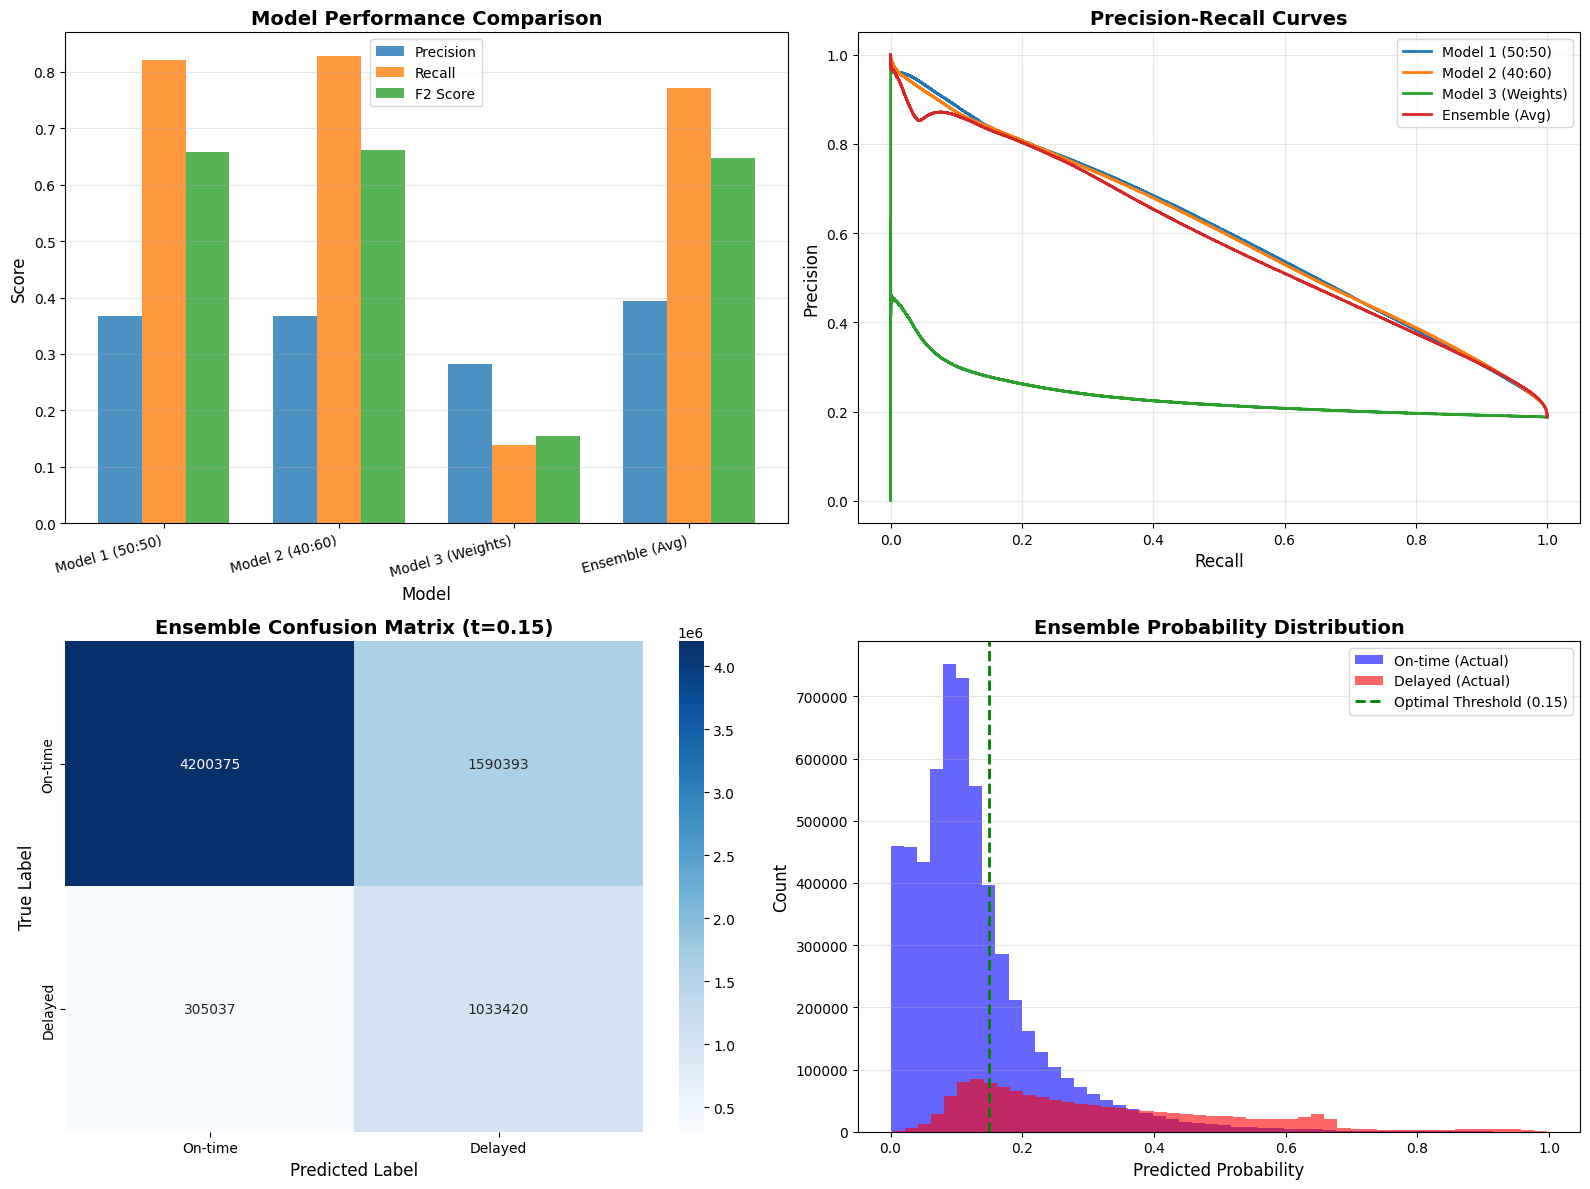


 Visualizations complete.


In [0]:
# ============================================================
# VISUALIZATIONS
# ============================================================
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Model Comparison Bar Chart
ax1 = axes[0, 0]
comp_df = pd.DataFrame(comparison_results)
x = np.arange(len(comp_df))
width = 0.25

ax1.bar(x - width, comp_df['precision'], width, label='Precision', alpha=0.8)
ax1.bar(x, comp_df['recall'], width, label='Recall', alpha=0.8)
ax1.bar(x + width, comp_df['f2'], width, label='F2 Score', alpha=0.8)

ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comp_df['model'], rotation=15, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Precision-Recall Curves
ax2 = axes[0, 1]
for model_name, y_prob in models_to_compare:
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_prob)
    ax2.plot(recall_curve, precision_curve, linewidth=2, label=model_name)

ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Ensemble Confusion Matrix
ax3 = axes[1, 0]
cm_ensemble = confusion_matrix(y_true, y_pred_ensemble)
sns.heatmap(cm_ensemble, annot=True, fmt="d", cmap="Blues", ax=ax3,
            xticklabels=["On-time", "Delayed"],
            yticklabels=["On-time", "Delayed"])
ax3.set_title(f'Ensemble Confusion Matrix (t={best_f2_threshold})', fontsize=14, fontweight='bold')
ax3.set_ylabel('True Label', fontsize=12)
ax3.set_xlabel('Predicted Label', fontsize=12)

# Plot 4: Probability Distribution
ax4 = axes[1, 1]
ax4.hist(y_prob_ensemble[y_true == 0], bins=50, alpha=0.6, label='On-time (Actual)', color='blue')
ax4.hist(y_prob_ensemble[y_true == 1], bins=50, alpha=0.6, label='Delayed (Actual)', color='red')
ax4.axvline(x=best_f2_threshold, color='green', linestyle='--', linewidth=2, label=f'Optimal Threshold ({best_f2_threshold})')
ax4.set_xlabel('Predicted Probability', fontsize=12)
ax4.set_ylabel('Count', fontsize=12)
ax4.set_title('Ensemble Probability Distribution', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n Visualizations complete.")

---
## 17. Final Summary

In [0]:
# ============================================================
# FINAL SUMMARY
# ============================================================
print("\n" + "="*60)
print("FINAL ENSEMBLE SUMMARY")
print("="*60)

print("\n1. ENSEMBLE CONFIGURATION:")
print(f"   Model 1: 50:50 undersampling ({train_m1_count:,} samples)")
print(f"   Model 2: 40:60 undersampling ({train_m2_count:,} samples)")
print(f"   Model 3: Original data ({total:,} samples)")
print(f"   Combination: Simple average")

print("\n2. TRAINING TIME:")
print(f"   Model 1: {training_time_m1:.2f}s")
print(f"   Model 2: {training_time_m2:.2f}s")
print(f"   Model 3: {training_time_m3:.2f}s")
print(f"   Total:   {total_training_time:.2f}s")

print("\n3. ENSEMBLE PERFORMANCE (at optimal threshold):")
print(f"   Threshold:  {best_f2_threshold}")
print(f"   Precision:  {best_result['precision']:.4f}")
print(f"   Recall:     {best_result['recall']:.4f} ← Catching {best_result['recall']*100:.1f}% of delays!")
print(f"   F1 Score:   {best_result['f1']:.4f}")
print(f"   F2 Score:   {best_result['f2']:.4f} ← Primary metric")
print(f"   AUC-PR:     {aupr:.4f}")

print("\n4. CONFUSION MATRIX:")
print(f"   True Positives:  {best_result['tp']:,} (Correctly predicted delays)")
print(f"   False Positives: {best_result['fp']:,} (False alarms)")
print(f"   True Negatives:  {best_result['tn']:,} (Correctly predicted on-time)")
print(f"   False Negatives: {best_result['fn']:,} (Missed delays)")

print("\n5. IMPROVEMENT OVER SINGLE MODEL:")
# Compare to original single model (assuming 20% recall)
original_recall = 0.2061
improvement = (best_result['recall'] - original_recall) * 100
print(f"   Original single model recall: {original_recall*100:.1f}%")
print(f"   Ensemble recall:              {best_result['recall']*100:.1f}%")
print(f"   Improvement:                  +{improvement:.1f} percentage points")

print("\n" + "="*60)
print(" ENSEMBLE TRAINING AND EVALUATION COMPLETE!")
print("="*60)


FINAL ENSEMBLE SUMMARY

1. ENSEMBLE CONFIGURATION:
   Model 1: 50:50 undersampling (5,945,573 samples)
   Model 2: 40:60 undersampling (4,965,869 samples)
   Model 3: Original data (16,454,983 samples)
   Combination: Simple average

2. TRAINING TIME:
   Model 1: 1345.19s
   Model 2: 1050.73s
   Model 3: 2340.69s
   Total:   4736.61s

3. ENSEMBLE PERFORMANCE (at optimal threshold):
   Threshold:  0.15
   Precision:  0.3939
   Recall:     0.7721 ← Catching 77.2% of delays!
   F1 Score:   0.5216
   F2 Score:   0.6477 ← Primary metric
   AUC-PR:     0.5831

4. CONFUSION MATRIX:
   True Positives:  1,033,420 (Correctly predicted delays)
   False Positives: 1,590,393 (False alarms)
   True Negatives:  4,200,375 (Correctly predicted on-time)
   False Negatives: 305,037 (Missed delays)

5. IMPROVEMENT OVER SINGLE MODEL:
   Original single model recall: 20.6%
   Ensemble recall:              77.2%
   Improvement:                  +56.6 percentage points

 ENSEMBLE TRAINING AND EVALUATION COMP

---
## 18. Save Models (Optional)

In [0]:
# ============================================================
# SAVE MODELS
# ============================================================
# Uncomment to save models

SAVE_PATH = "dbfs:/student-groups/Group_4_4/mlp"  # UPDATE THIS

model_1.write().overwrite().save(f"{SAVE_PATH}/model_1_50_50_2")
model_2.write().overwrite().save(f"{SAVE_PATH}/model_2_40_60_2")
model_3.write().overwrite().save(f"{SAVE_PATH}/model_3_weights_2")

print(" Models saved.")

 Models saved.


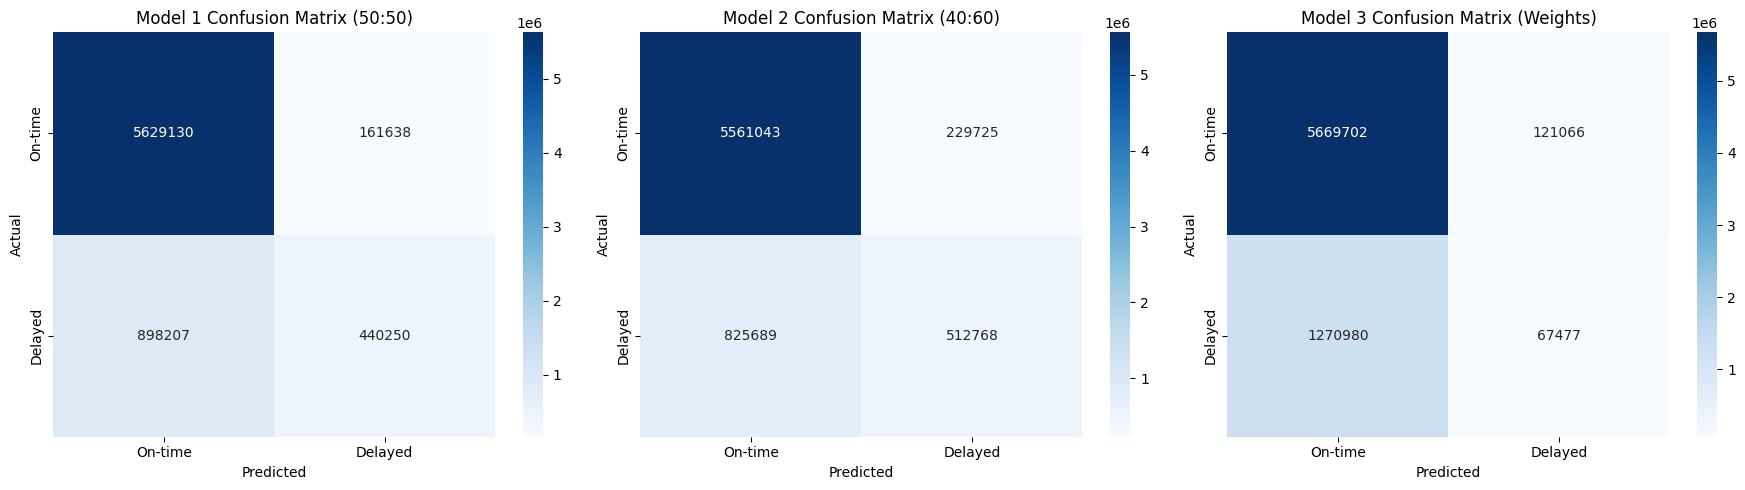

In [0]:
from sklearn.metrics import confusion_matrix

cm_m1 = confusion_matrix(y_true, (y_prob_m1 >= 0.5).astype(int))
cm_m2 = confusion_matrix(y_true, (y_prob_m2 >= 0.5).astype(int))
cm_m3 = confusion_matrix(y_true, (y_prob_m3 >= 0.5).astype(int))

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(cm_m1, annot=True, fmt="d", cmap="Blues", ax=axes[0],
            xticklabels=["On-time", "Delayed"], yticklabels=["On-time", "Delayed"])
axes[0].set_title("Model 1 Confusion Matrix (50:50)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_m2, annot=True, fmt="d", cmap="Blues", ax=axes[1],
            xticklabels=["On-time", "Delayed"], yticklabels=["On-time", "Delayed"])
axes[1].set_title("Model 2 Confusion Matrix (40:60)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

sns.heatmap(cm_m3, annot=True, fmt="d", cmap="Blues", ax=axes[2],
            xticklabels=["On-time", "Delayed"], yticklabels=["On-time", "Delayed"])
axes[2].set_title("Model 3 Confusion Matrix (Weights)")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")

plt.tight_layout()
plt.show()